In [48]:
import GWPhotonCounting
import jax.numpy as jnp
import jax
import numpy as np
import bilby
from bilby_cython.geometry import frequency_dependent_detector_tensor

import json
import sys
import os

from scipy.optimize import minimize

from astropy.cosmology import Planck18
import astropy.units as u

# injected snr
idx = 0

from tqdm import tqdm

import jax

import os


jax.config.update("jax_enable_x64", True)

frequencies = jnp.sort(jnp.fft.fftfreq(2**12, d=1/1e4))

# TODO make this work on non-linear frequencies array
dF = frequencies[1] - frequencies[0]
duration = 1/dF
print("DURATION: ", duration)

#frequencies = jnp.sort(jnp.fft.fftfreq(2**12, d=1/1e4))
print("freq max", np.max(frequencies))
print("dF", frequencies[-1] - frequencies[-2])

# Setting up the two detectors to compare the
detector_nosqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_shot_psd_nosqz.csv',
    '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_classical_psd.csv',
    gamma=20, random_seed=1632, N_frequency_spaces=40, N_time_spaces=5)

detector_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_total_psd_sqz.csv', None,
    gamma=20, random_seed=1632, N_frequency_spaces=40, N_time_spaces=5)


#Loading in the individual analysis from the sample
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/mcculler/photon_counting/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()
#dataset = np.genfromtxt(f'/home/mcculler/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_260213.dat') #bns_pm_dataset_MLE_250609
dataset = np.genfromtxt(f'/home/mcculler/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_260214.dat') #bns_pm_dataset_MLE_250609
#dataset = np.genfromtxt(f'/home/mcculler/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250609.dat') #bns_pm_dataset_MLE_250609

# OK, now sorting on SNR for the first 10000!!!
if idx <= 10000:
    #mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset[:10000, :13].T
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, t0, snr, snr_sqz = dataset[:10000, :14].T
    #print(dataset.shape)
    #print(snr.shape)
    snr_idx = np.argsort(-snr)
    #print(snr_idx.shape)
    sorted_dataset = dataset[snr_idx]
    #print(sorted_dataset.shape)
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, t0_fit, snr, snr_sqz = sorted_dataset[idx, :14]
else:
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, t0_fit, snr, snr_sqz = dataset[idx, :14]

amplitude_samples = dataset[:, 9] #* Planck18.luminosity_distance( dataset[:,1]).value /Planck18.luminosity_distance(z).value
gamma_samples = dataset[:, 8]
f0_samples = dataset[:, 7]
iQ_samples = gamma_samples / f0_samples

# Compute the expected number of photons and the strain
PM_strain = KNNModel.generate_strain(detector_nosqz, frequencies, mtots, phi, z, ra, dec, iota, psi)

snr = detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)
snr_sqz = detector_sqz.calculate_optimal_snr(PM_strain, frequencies)
print('SNRs are: ', snr, snr_sqz)
print('f0_fit: ', f0_fit)
print('t0_fit: ', t0_fit)

# # What I'm doing here is generating a Lorentzian signal with the same amplitude as the KNN model
# # I'm using this as a replacemenet/test because then the amplitude of the signal that we recover with and inject with is the same!
# PM_strain = LorentzianModel.generate_strain(
#     detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A_fit, phase=0, t0=0)[0]

# if detector_nosqz.calculate_optimal_snr(PM_strain, frequencies) > snr:
#     A = A_fit* snr / detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)

#     PM_strain = LorentzianModel.generate_strain(
#         detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A, phase=0, t0=0)[0]


# print(A_fit, detector_nosqz.calculate_optimal_snr(PM_strain, frequencies), snr)

# Getting the frequencies
R1d6s = np.linspace(10,14,100) # 25
f0_R1d6s = GWPhotonCounting.hierarchical.frequency_model(mtots, R1d6s)/(1+z)

# Setting up the likelihood
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()
gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()
convolved_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

# Marginalizing over the likelihood
N_samples = 100
N_t0s = 10

np.random.seed()
n_exp = np.sum(detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies))
n_self = detector_nosqz.calculate_signal_photon_expectation_self(PM_strain, frequencies)
print('Expected number of photons (vs HD), (into templates), (full power): ', snr**2/4, n_exp, n_self)
# Calculation for the CE1 detector
observed_photons, signal_photons, noise_photons = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d01 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.01 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d1 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.1 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d5 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.5 * detector_nosqz.noise_photon_expectation)
observed_photons_no_background = signal_photons

likelihood_event_i = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d01 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d1 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d5 = np.zeros(len(f0_R1d6s))
likelihood_event_i_no_background = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_15db = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_20db = np.zeros(len(f0_R1d6s))
likelihood_event_i_strainMx = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_15dbMx = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_20dbMx = np.zeros(len(f0_R1d6s))

t0s = jnp.linspace(-0.01, 0.03, N_t0s)

# Attempt at fixing the calculation in the hierarchical analysis.....
def neg_logl_cost_function(x0, strain, frequencies, noise_psd):

    f0, gamma, log10A, phase, t0 = x0

    t0s = np.array([t0])

    # Calculate the expected strain
    lorentzian_strain = LorentzianModel.generate_strain(
        detector_sqz, frequencies, f0=f0, gamma=gamma, A=10**log10A, phase=phase, t0=t0s)

    # Calculate the log-likelihood
    logl = gaussian_likelihood(strain, lorentzian_strain, noise_psd,frequencies)

    # Return the negative logl
    return -logl


def neg_logl_cost_function_split(x0, strain, frequencies):

    f0, gamma, log10A, phase = x0

    t0s = jnp.linspace(-0.02, 0.02, 100)

    # Calculate the expected strain
    lorentzian_strain = LorentzianModel.generate_strain(
        detector_nosqz, frequencies, f0=f0, gamma=gamma, A=10**log10A, phase=phase, t0=t0s)

    # Return the negative logl
    t0s, logl = np.array([
		[t0s[i], gaussian_likelihood(strain, lorentzian_strain[i].reshape(1, -1), jnp.ones(len(frequencies))*1e-55,frequencies)]
		for i in range(len(t0s))
	]).T
    midx = np.argmin(-logl)
    return t0s[midx], logl[midx]


result_fits = []
neg_logls = []
for i in tqdm(range(100)):
    params_0 = [np.abs(np.random.uniform(.995,1.005) * frequencies[np.argmax(np.abs(PM_strain))]), np.random.uniform(1,100), np.random.uniform(-10,1), np.random.uniform(0,2*np.pi), np.random.uniform(-.02, .05)]
    minimize_result = minimize(neg_logl_cost_function,
                                x0=params_0,
                                args=(PM_strain/np.max(np.abs(PM_strain)), frequencies, np.ones_like(frequencies)),
                                bounds=((500, 5000), (0, 200), (-5, 5), (0, 2*np.pi), (-.05, .1)))

    result_fits.append(minimize_result.x)
    neg_logls.append(minimize_result.fun)

fpeak_fit, gamma_fit, log10A_fit_pc, phase_fit, t0_fit = result_fits[np.argmin(neg_logls)]
print('fpeak_fit: ', fpeak_fit)
print('amp_fit: ', 10**log10A_fit_pc)
print("T0:", t0_fit)
#which = neg_logl_cost_function_split((fpeak_fit, gamma_fit, log10A_fit_pc, phase_fit), PM_strain, frequencies)
#t0_fit, logl = which

neg_logl_pc = np.min(neg_logls)
fitted_signal = LorentzianModel.generate_strain(
        detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_pc * np.max(np.abs(PM_strain)), phase=phase_fit, t0=t0_fit)[0]

snr_fit_pc = detector_nosqz.calculate_optimal_snr(fitted_signal, frequencies)
snr_cross = detector_nosqz.calculate_inner_product(PM_strain, fitted_signal, frequencies)
SNR_frac = (snr_cross**2 / snr_fit_pc / snr)
print("SNR, SNR_L, SNR_X, fraction_overlap: ", snr, snr_fit_pc, snr_cross, SNR_frac)

# result_fits = []
# neg_logls = []
# #params_0 = [np.abs(frequencies[np.argmax(np.abs(PM_strain))]), np.random.uniform(0,200), jnp.log10(np.max(np.abs(PM_strain))), np.random.uniform(0,2*np.pi)]
# for i in tqdm(range(100)):
#     params_0 = [np.random.uniform(500,5000), np.random.uniform(0,200), np.log10(A_fit), np.random.uniform(0,2*np.pi)]
#     minimize_result = minimize(neg_logl_cost_function,
#                                 x0=params_0,
#                                 args=(PM_strain, frequencies, detector_sqz.total_psd),
#                                 bounds=((500, 5000), (0, 200), (-40, -21), (0, 2*np.pi)))
#     _, _, log10A_fit, _ = minimize_result.x

#     result_fits.append(minimize_result.x)
#     neg_logls.append(minimize_result.fun)

# fpeak_fit, gamma_fit, log10A_fit_strain, phase_fit = result_fits[np.argmin(neg_logls)]
# neg_logl_strain = np.min(neg_logls)
# fitted_signal = LorentzianModel.generate_strain(
#         detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_strain, phase=phase_fit, t0=0)[0]
# snr_fit_strain = detector_sqz.calculate_optimal_snr(fitted_signal, frequencies)

# log10A_fits = []
# neg_logls = []
# for i in tqdm(range(100)):
#     params_0 = [np.random.uniform(500,5000), np.random.uniform(0,200), np.log10(A_fit), np.random.uniform(0,2*np.pi)]
#     minimize_result = minimize(neg_logl_cost_function,
#                                 x0=params_0,
#                                 args=(PM_strain, frequencies, 10**(-0.5) * detector_sqz.total_psd),
#                                 bounds=((500, 5000), (0, 200), (-40, -21), (0, 2*np.pi)))
#     _, _, log10A_fit, _ = minimize_result.x

#     result_fits.append(minimize_result.x)
# #     neg_logls.append(minimize_result.fun)

# fpeak_fit, gamma_fit, log10A_fit_strain_15db, phase_fit = result_fits[np.argmin(neg_logls)]
# neg_logl_strain_15db = np.min(neg_logls)
# fitted_signal = LorentzianModel.generate_strain(
#         detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_strain_15db, phase=phase_fit, t0=0)[0]
# snr_fit_strain_15db = detector_sqz.calculate_optimal_snr(fitted_signal, frequencies) *(10**(-0.5))

print('Log10A fit is: ', A_fit, 10**log10A_fit_pc * np.max(np.abs(PM_strain)), log10A_fit_pc)#, log10A_fit_strain, log10A_fit_strain_15db)
print('SNRs are (PM, SQZ, FIT, CROSS, FRAC): ', snr, snr_sqz, snr_fit_pc, snr_cross, SNR_frac)#, snr_fit_strain, snr_fit_strain_15db)
print('neg_logls are: ', neg_logl_pc)#, neg_logl_strain * np.sum(detector_sqz.total_psd/detector_nosqz.total_psd), neg_logl_strain_15db * np.sum(detector_sqz.total_psd*10**(-0.5)/detector_nosqz.total_psd))
print('Photon counts are: ', np.sum(signal_photons), np.sum(noise_photons), np.sum(noise_photons_0d1))


DURATION:  0.4096
freq max 4997.55859375
dF 2.44140625
N_total_filters for Nyquist: 272
N_total_filters from user: 400
FSHAPE (400, 4096)
eff 1.0
eff15 0.8992614951242911
N_total_filters for Nyquist: 272
N_total_filters from user: 400
FSHAPE (400, 4096)
eff 1.0000000000000002
eff15 0.8990615204196348
SNRs are:  0.7670620174261543 2.140736407962121
f0_fit:  3091.912668718127
t0_fit:  0.008282828282828288
Expected number of photons (vs HD), (into templates), (full power):  0.14709603464447046 0.1446885559819976 (np.float64(0.14857995097889787), np.float64(0.14604988247643724))


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]

fpeak_fit:  3076.5946793687326
amp_fit:  0.47531239032667294
T0: 0.008480644722185073
SNR, SNR_L, SNR_X, fraction_overlap:  0.7670620174261543 0.5556734279319208 0.5536553532269457 0.7191655891708553
Log10A fit is:  3.10977216072145e-26 1.4005538998989824e-26 -0.3230208644757728
SNRs are (PM, SQZ, FIT, CROSS, FRAC):  0.7670620174261543 2.140736407962121 0.5556734279319208 0.5536553532269457 0.7191655891708553
neg_logls are:  -3852.1846462877097
Photon counts are:  0 0.0 0.0


/tmp/ipykernel_1312766/1180462139.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


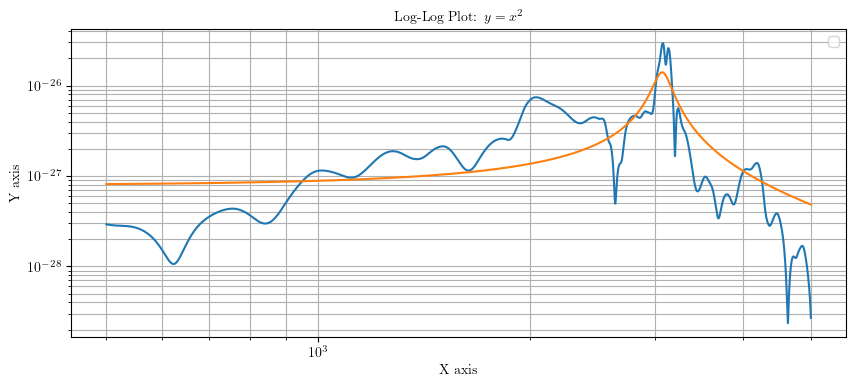

In [49]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #
fsel = frequencies > 500

ax1.loglog(frequencies[fsel], abs(PM_strain[fsel]))
ax1.loglog(frequencies[fsel], abs(fitted_signal[fsel]))
ax1.set_title('Log-Log Plot: $y=x^2$')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
ax1.legend()

/tmp/ipykernel_1312766/4106249755.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


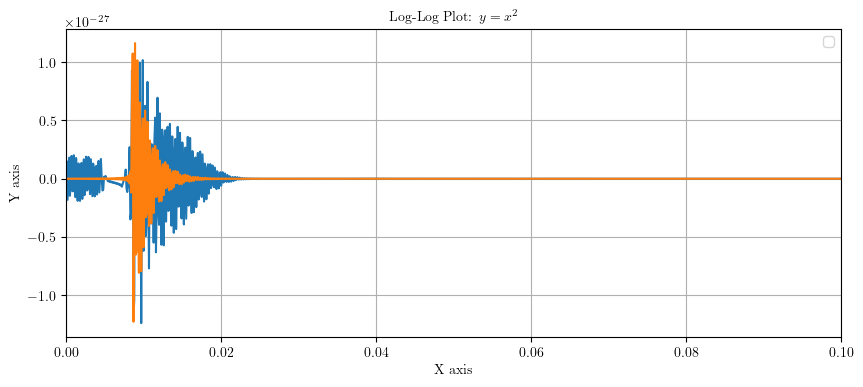

In [50]:
T = np.arange(len(frequencies)) / (2 * np.max(frequencies))
PM_strainT = np.fft.ifft(np.fft.ifftshift(PM_strain))
fitted_signalT = np.fft.ifft(np.fft.ifftshift(fitted_signal))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #

ax1.plot(T, PM_strainT.real)
ax1.plot(T, fitted_signalT.real)
#ax1.loglog(frequencies[fsel], abs(fitted_signal[fsel]))
ax1.set_title('Log-Log Plot: $y=x^2$')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
ax1.set_xlim(0, 0.1)
ax1.legend()

In [51]:
frequencies

Array([-5000.        , -4997.55859375, -4995.1171875 , ...,
        4992.67578125,  4995.1171875 ,  4997.55859375], dtype=float64)

In [52]:
idx_close = np.argwhere(abs(np.array(detector_nosqz.filter_labels)[:, 0] - fpeak_fit) < 100)[:, 0]

/tmp/ipykernel_1312766/3154502538.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


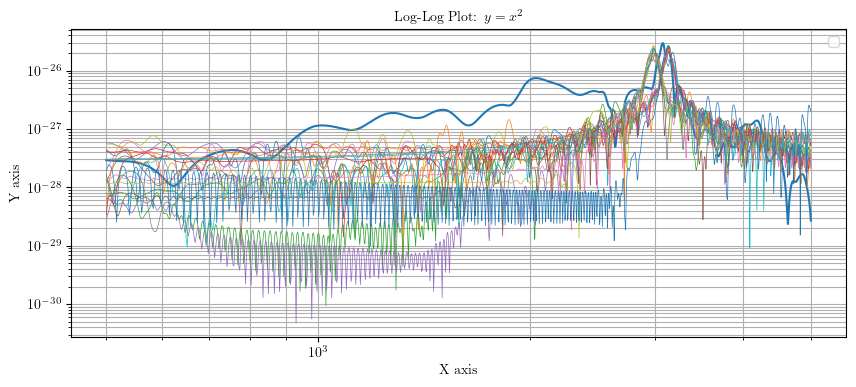

In [53]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #
fsel = frequencies > 500

ax1.loglog(frequencies[fsel], abs(PM_strain[fsel]))
for idx in idx_close:
    ax1.loglog(frequencies[fsel], 3e-25 * abs(detector_nosqz.filter_functions[idx][fsel]), lw=0.5)
ax1.set_title('Log-Log Plot: $y=x^2$')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
ax1.legend()

/tmp/ipykernel_1312766/2821275275.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


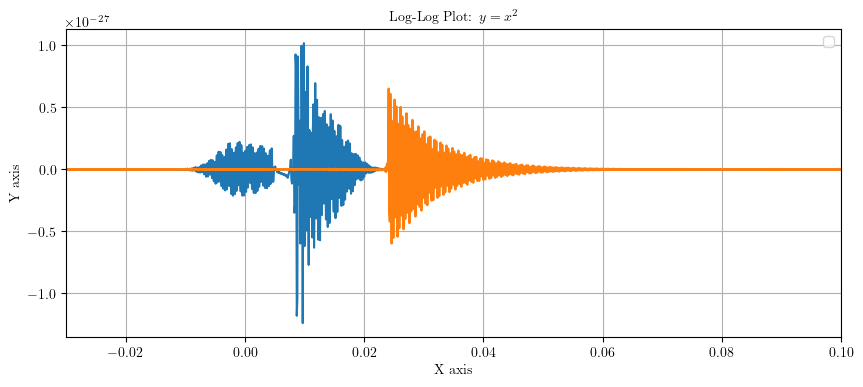

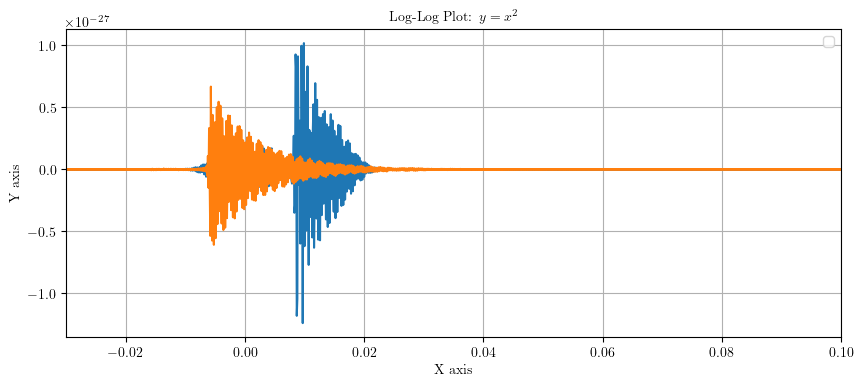

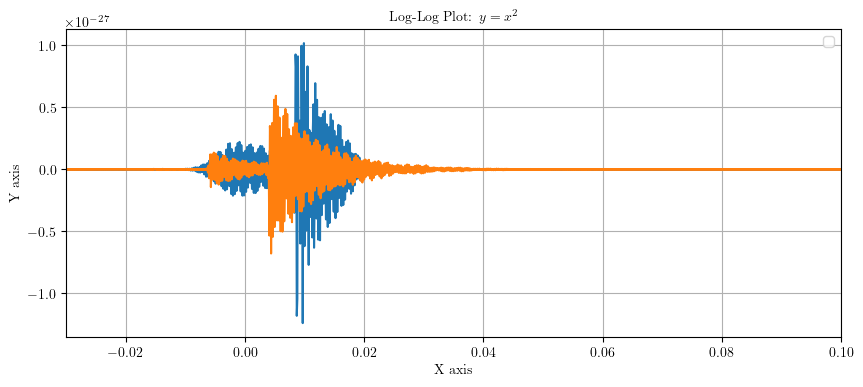

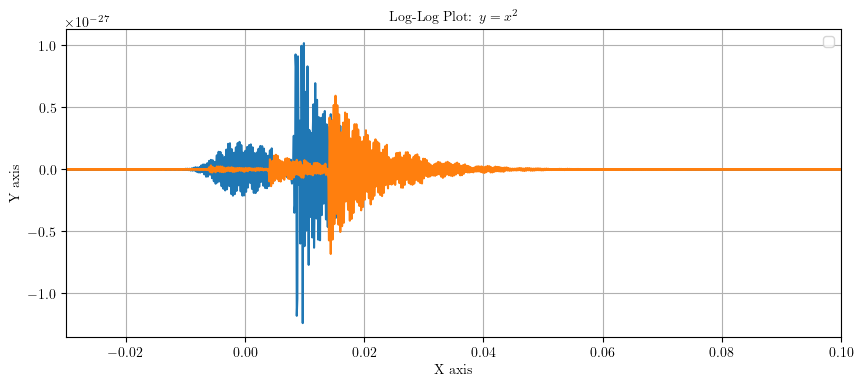

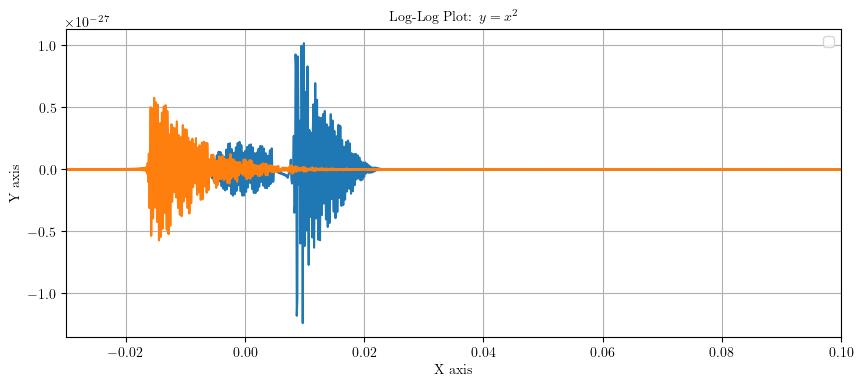

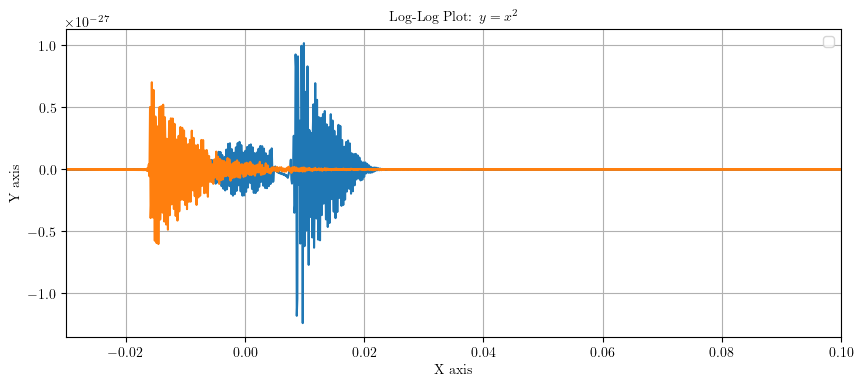

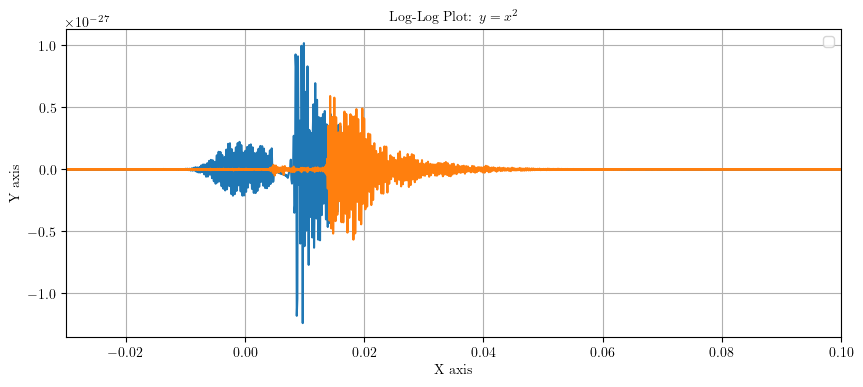

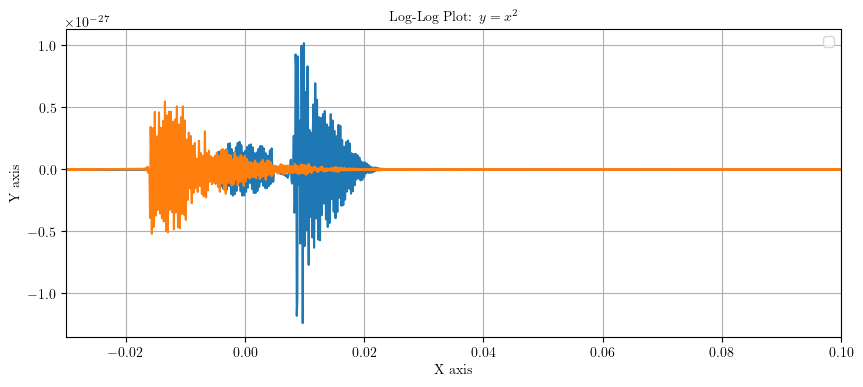

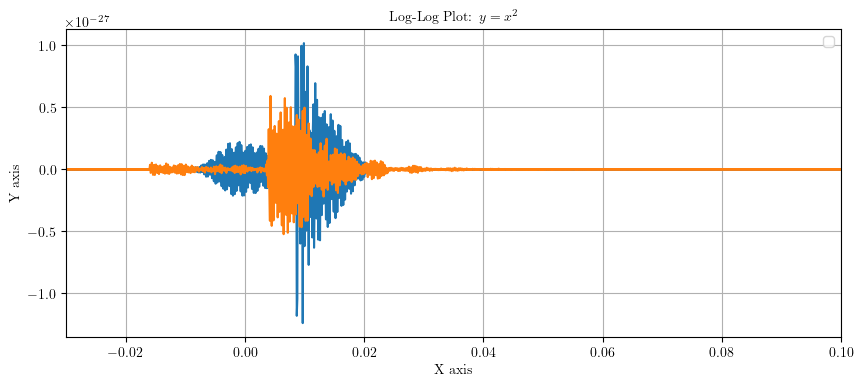

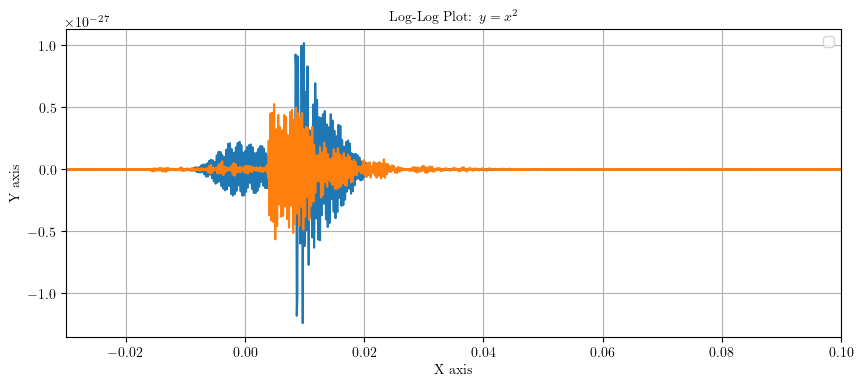

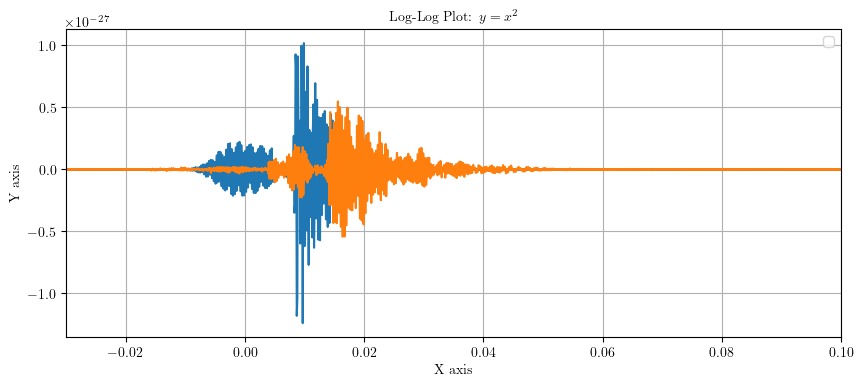

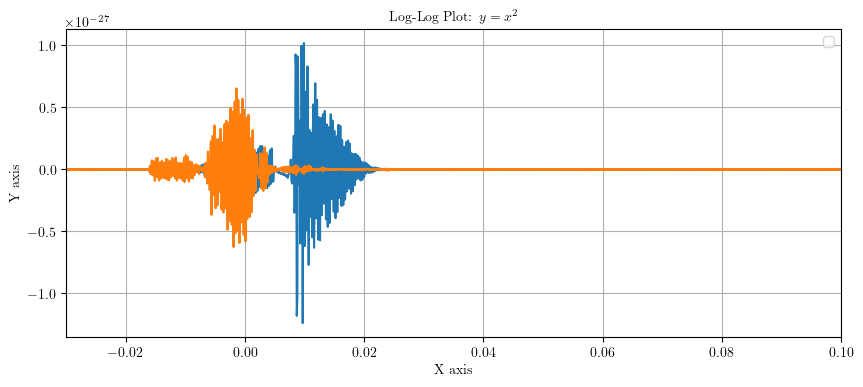

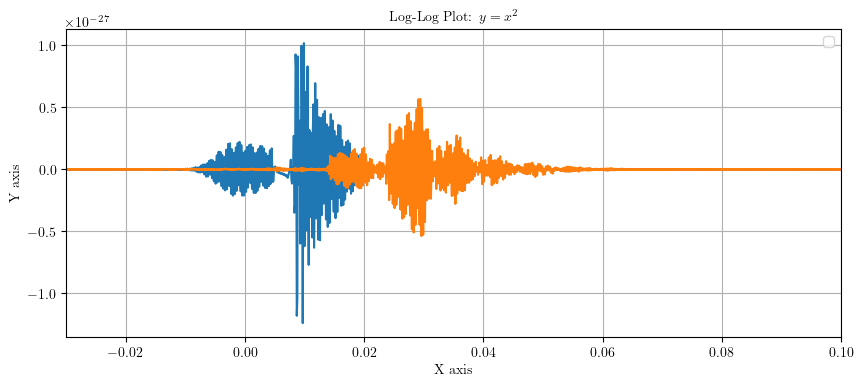

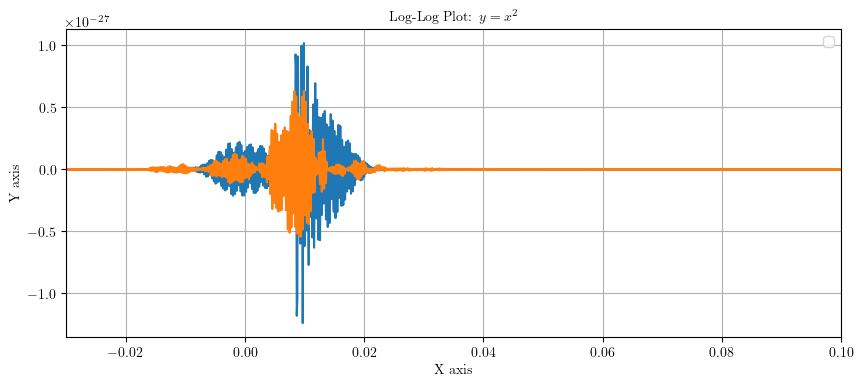

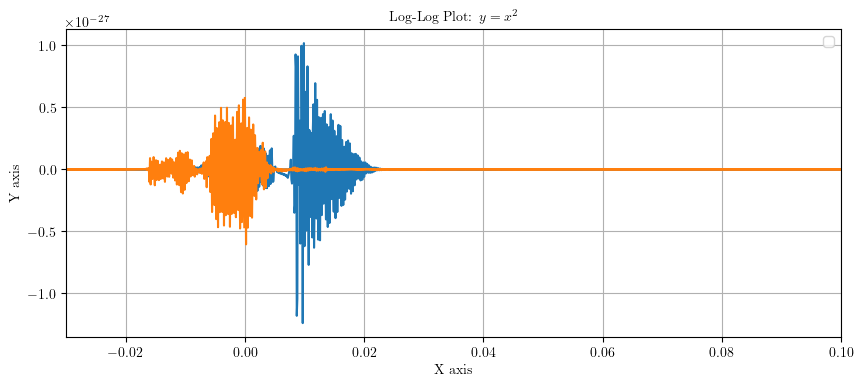

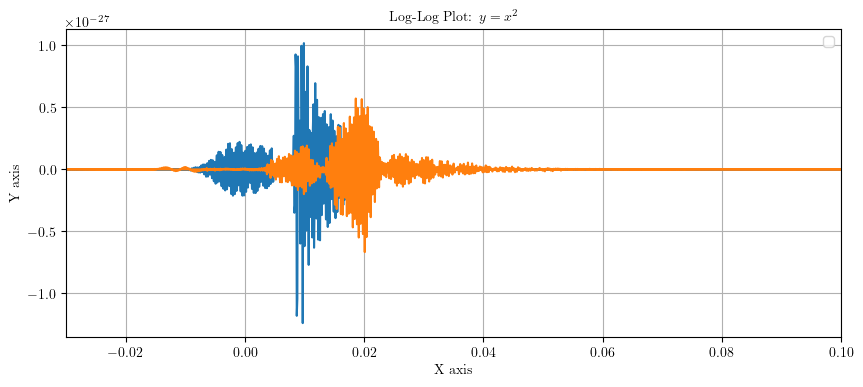

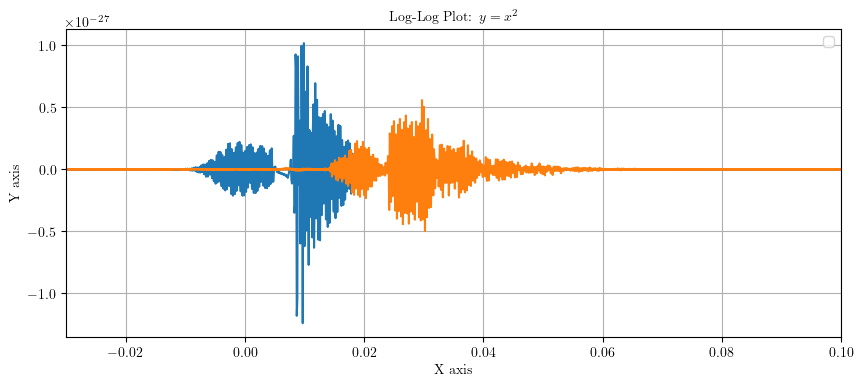

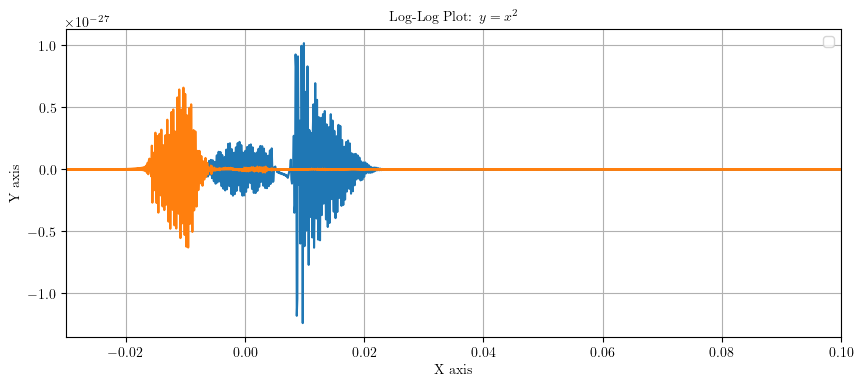

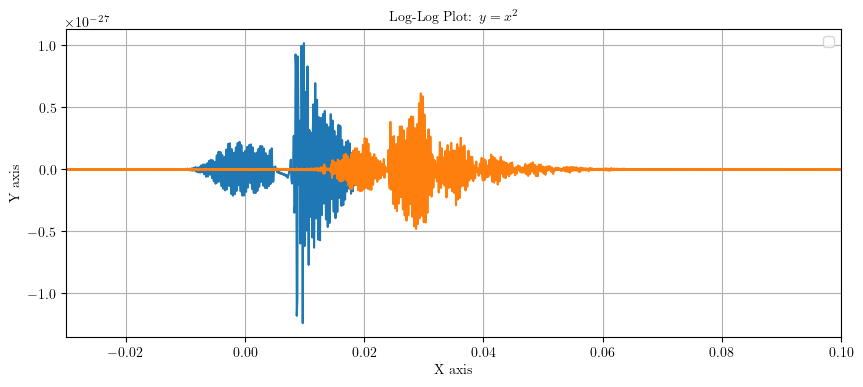

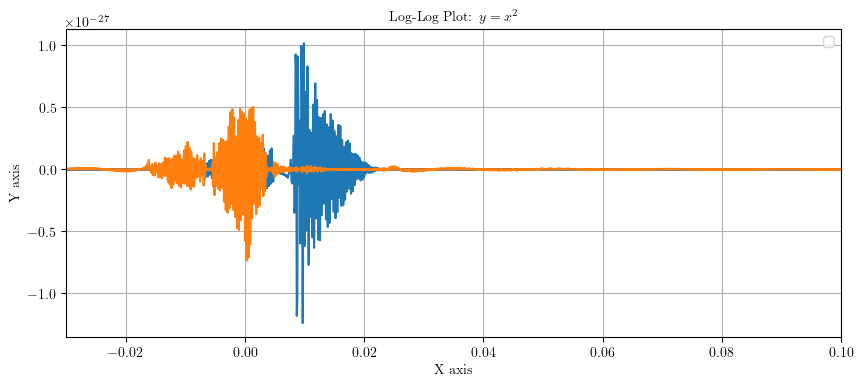

In [54]:
for idx in idx_close:
    T = np.array(np.arange(len(frequencies)) / (2 * np.max(frequencies)))
    T[len(frequencies)//2:] -= len(frequencies) / (2 * np.max(frequencies))
    PM_strainT = np.fft.ifft(np.fft.ifftshift(PM_strain))
    fitted_signalT = np.fft.ifft(np.fft.ifftshift(3e-25 * detector_nosqz.filter_functions[idx]))
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #

    ax1.plot(T, PM_strainT.real)
    ax1.plot(T, fitted_signalT.real)
    #ax1.loglog(frequencies[fsel], abs(fitted_signal[fsel]))
    ax1.set_title('Log-Log Plot: $y=x^2$')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
    ax1.set_xlim(-0.03, 0.1)
    ax1.legend()

In [21]:
# Setting up the likelihood
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()
gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()
convolved_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

noise_rlz = gaussian_likelihood.generate_realization(detector_sqz.total_psd, frequencies)
observed_strain = PM_strain + noise_rlz
observed_strain_15db = PM_strain + (10**(-0.5))**0.5 * noise_rlz
observed_strain_20db = PM_strain + (10**(-1))**0.5 * noise_rlz

In [22]:
logl = gaussian_likelihood.log_likelihood(PM_strain.reshape(1, -1), 0*PM_strain.reshape(1, -1), detector_sqz.total_psd,frequencies) - len(frequencies)
logl[0]

Array(-1.0368199, dtype=float64)

In [23]:
snr_sqz = detector_sqz.calculate_optimal_snr(PM_strain, frequencies, fmin=-1, fmax=10e3)
snr_sqz

Array(1.01824354, dtype=float64)

In [44]:
rlz_logl = []
for i in range(3000):
    noise_rlz = gaussian_likelihood.generate_realization(detector_sqz.total_psd, frequencies)
    logl = gaussian_likelihood.log_likelihood(noise_rlz.reshape(1, -1), 0*noise_rlz.reshape(1, -1), detector_sqz.total_psd,frequencies)
    rlz_logl.append(logl[0])

(array([  1.,   0.,   6.,   4.,  13.,  14.,  37.,  69.,  99., 132., 150.,
        184., 253., 299., 313., 297., 252., 255., 201., 154., 106.,  68.,
         45.,  26.,  10.,   8.,   0.,   1.,   2.,   1.]),
 array([-338.83927469, -315.68284969, -292.5264247 , -269.3699997 ,
        -246.2135747 , -223.0571497 , -199.9007247 , -176.7442997 ,
        -153.5878747 , -130.4314497 , -107.2750247 ,  -84.1185997 ,
         -60.9621747 ,  -37.8057497 ,  -14.6493247 ,    8.5071003 ,
          31.6635253 ,   54.8199503 ,   77.9763753 ,  101.1328003 ,
         124.2892253 ,  147.4456503 ,  170.6020753 ,  193.7585003 ,
         216.91492529,  240.07135029,  263.22777529,  286.38420029,
         309.54062529,  332.69705029,  355.85347529]),
 <BarContainer object of 30 artists>)

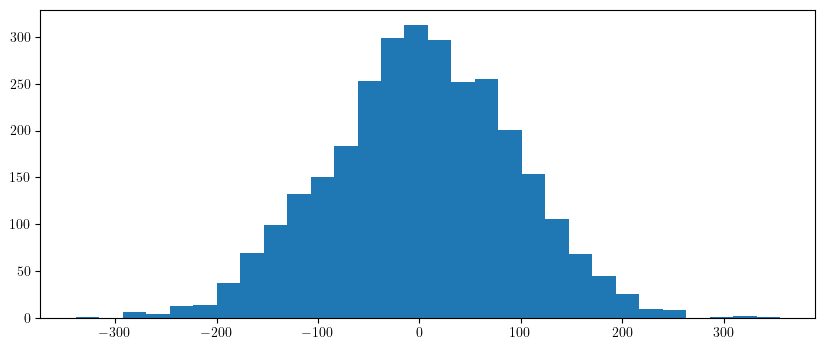

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #
ax1.hist(rlz_logl, bins=30)

In [47]:
np.var(rlz_logl) / (2**12)
#This is correct

np.float64(2.045818302327481)

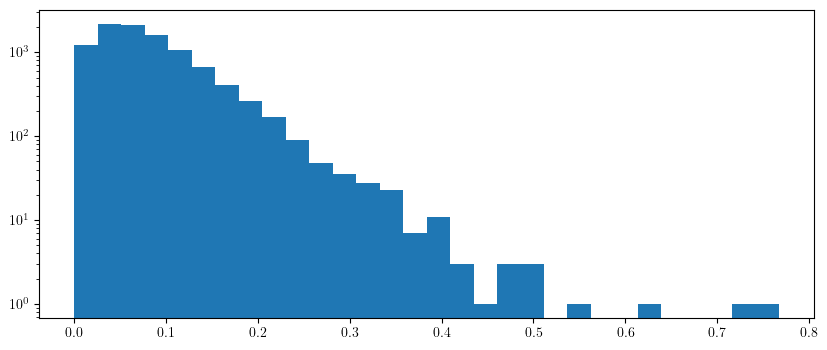

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #
mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, t0_fit, snr, snr_sqz = sorted_dataset[:, :14].T
ax1.hist(snr, bins=30)
ax1.set_yscale('log')